*Francisco Javier Sáez Maldonado*

# Ejercicio 1: Gambler's Ruin

Consideramos el problema *Gambler's Ruin*, en el que se pretende calcular el número medio de jugadas que tarda un jugador, que se encuentra en una casa de apuestas, en arruinarse apostando.  Podemos considerar para ello la siguiente cadena de Markov que representa nuestro problema:

![gamblers_ruin](gamblers_ruin.PNG)

Consideramos que:

- El estado (capital) inicial es el $m$ (que puede ser seleccionado por nosotros).
- En cada jugada se juega $1$ unidad de moneda.
- El juego es equo, es decir, en este caso $p = q = 1/2$.

Se pretende estimar, repitiendo el experimento un número determinado de veces, la media y la varianza que tarda el jugador en arruinarse considerando un capital inicial de $1,\dots,50$ unidades.

Para esto, recordamos lo que queremos es estimar empíricamente el valor **teórico** del *first hitting time* de la posición $0$ de la cadena de Markov, es decir:
$$
H^0(\omega) = inf \{t \geq 0 \ | \ X_w(\omega) = 0\}.
$$
En este problema, se sabe que la probabilidad de arruinarse es 1, es decir: $h_n = \mathbb P_n(\text{hit } 0) = 1$. Por ello, queremos estudiar cuál es el tiempo medio $k_m$ de que esto ocurra. Vimos durantes las clases que este $h_n$ es $1$ puesa este problema proviene de (en virtud del **teorema 3.5** de los apuntes del profesor) encontrar la solución teórica al sistema de ecuaciones en recurrencia que en el caso general viene dado por:
$$
\begin{cases}
h_0 = 0 \\
h_m = p h_{m-1} + q h_{m+1} & m = 1,2,\dots
\end{cases}
$$
cuya solución teórica es justamente:
$$
h_n = 1 - A + A \left(\frac{q}{p}\right)^n.
$$
En nuestro caso particular donde  $p = q = 1/2$, se tiene que $h_n = 1 + Bn$ y la condición $h_n \leq 1$ fuerza a que tengamos $B = 0$, lo que implica que $h_n = 1$, así que siempre nos acabaremos arruinando.

A la hora de **simular** esta cadena de Markov, tenemos que tener en cuenta la consideración de que puede haber casos en los que el jugador no se arruine nunca, porque se mantenga estable en una cantidad $k$ o porque vaya ascendiendo en esa cantidad debido al azar. Es por ello que establecemos un **máximo de iteraciones** en $10^5$.

Tras estas consideraciones, la simulación es sencilla: generar un número aleatorio, actualizar el estado a $m+1$ o $m-1$ según el número aleatorio generado, y repetir el proceso hasta que $m = 0$ o se alcance el número máximo de iteraciones. 

Creamos una clase `GambleMC` para encapsular el comportamiento del jugador.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from kalman_aux import *
from scipy.stats import multivariate_normal

np.random.seed(123)

In [2]:
RUIN = 0

class GamblerMC:
    
    
    def __init__(self, m, p = 0.5):
        self.ini_m = m
        self.curr_m = m
        self.p = p
        
    def _next(self):
        """
        Simulates a step in the Gambler's ruin MC
        """
        
        # Generate random uniform(0,1)
        gen = np.random.rand()
        
        # Update to m+1 with probability p and to m -1 with probability 1-p
        self.curr_m = self.curr_m + 1 if gen <= self.p else self.curr_m - 1
        
        return self.curr_m
    
    def simulation(self, max_iterations = 10**5):
        """
        Function that simulates the behaviour of the Gambler.
        Args:
            - max_iterations: maximum number of iterations that we simulate
        Return:
            - nº of plays if the gambler gets to be ruined
            - max_iterations If the gambler does not get to be ruined
        """
        if self.curr_m == RUIN:
            return 0
        
        for i in range(1,max_iterations+1):
            
            self._next()
            
            if self.curr_m == RUIN:
                self.curr_m = self.ini_m
                return i
            
            
        
        # Reset current m
        self.curr_m = self.ini_m
        
        return max_iterations
        


Con esta clase, podemos definir los diferentes estados iniciales que queremos obtener ( $m = 0,\dots,50$) y lanzar $100$ simulaciones del experimento por cada uno de esos estados. Entonces, calculamos su media y su varianza.

In [3]:
initial_m = np.arange(1,51,1)
n_simulations = 100
results = {}
for i in initial_m:
    gambler = GamblerMC(m = i)
    res = [gambler.simulation() for j in range(n_simulations)]
    results[str(i)] = [np.mean(res),np.std(res)]


In [4]:
def plot_average(results, regression = []):
    """
    
    """
    ys = np.array([results[str(i)][0] for i in initial_m])
    stds = np.array([results[str(i)][1] for i in initial_m])
    
    min_ys = ys - stds
    min_ys[min_ys < 0] = 0
    
    fig,ax = plt.subplots()
    ax.plot(initial_m,ys,label = "Average Iterations ")
    ax.fill_between(initial_m,min_ys,ys+stds,alpha = 0.2,label = "Standard deviation")
    ax.set_title("Average number of iterations of the Gambler's Ruin example")
    ax.set_xlabel("Initial m")
    ax.set_ylabel("Number of iterations")
    
    if len(regression) > 0:
        ax.plot(regression[0],regression[1], label = "Regression model")
    plt.legend(loc="upper left")
    plt.show()

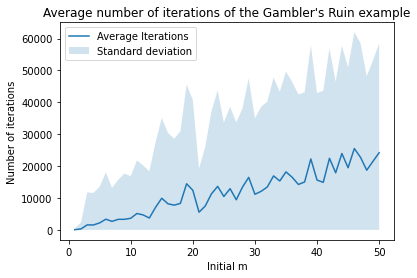

In [5]:
plot_average(results)

Como era de esperar, el número medio de iteraciones que tienen que darse para que el jugador se arruine crece cuando aumenta la cantidad inicial $m$. Esto es bastante lógico, pues ya de por sí la distancia a cero aumenta, y por tanto es menos probable que el jugador se arruine en pocas jugadas y pueda hacer crecer su capital para alejarse de la ruina. Como vemos, también la desviación típica es bastante grande, lo cual también tiene sentido pues tendremos iteraciones en las que el jugador no se arruine y difieran en cantidad de pasos hasta arruinarse bastante respecto a la media.

## Estimación de T(e)

A continuación, se pide dar una **estimación** de la función $T(e)$, que da el **tiempo medio necesario para arruinarse** en función de la cantidad inicial de capital $e$.

Para ello, no tenemos otra opción que usar las medias obtenidas anteriormente y tratar de ajustar una recta mediante regresión lineal que minimice el error cuadrático medio a las medias anteriores. Esto es bastante sencillo de realizar utilizando `sklearn`.

In [6]:
X,y = initial_m.reshape(-1,1), [results[str(i)][0] for i in initial_m]

reg = LinearRegression()

reg.fit(X,y)

print("MSE for the linear model = {}".format(mean_squared_error(reg.predict(X),y)))
print("R2 score for the linear model = {}".format(r2_score(reg.predict(X),y)))

print("The model is: \n \t Y = ax + b = {} x + {}".format(reg.coef_[0],reg.intercept_))

MSE for the linear model = 5065038.824146578
R2 score for the linear model = 0.8863898989600999
The model is: 
 	 Y = ax + b = 462.6903174069627 x + -59.544293877548625


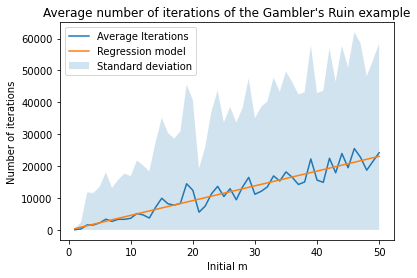

In [7]:
plot_average(results, [initial_m, reg.predict(X)])

Tras ajustar el modelo, la recta de regresión que obtenemos (mostrada también en la salida por consola) es 
$$
Y = 462.6903174069627 x + -59.5442938775486.
$$
Se muestran también el el error cuadrático medio y el coeficiente $R^2$. Aunque el error cuadrático medio pueda parecer muy alto, esto es debido a que los residuos son bastante grandes y estamos trabajando con valores muy grandes, como podemos observar en el eje $y$. El coeficiente $R^2$ nos indica que estamos explicando gran parte de la variabilidad de los datos con nuestro modelo (recordamos que $0 \leq R^2 \leq 1$, por lo que aceptamos este modelo lineal.

Por último, se nos pide que realicemos una predicción utilizando $e = 200$. Podemos hacerlo prediciendo con nuestro modelo lineal.

In [8]:
value = np.array([200]).reshape(-1,1)
print("Prediction for e = 200: {}".format(reg.predict(value)[0]))

Prediction for e = 200: 92478.51918751499


Se obtiene que el número medio es bastante cercano a $10^5$, por lo que concluimos que con $e = 200$, en la mayoría de ocasiones el jugador no ha llegado a arruinarse aún (recordemos que el número máximo de pasos que se pueden dar es $10^5$).

# Ejercicio 2

Crear cuatro sistemas dinámicos del tipo:

$$
\begin{cases}
x_{t+1} = \mathbf{A} x_t + \mathbf{B}u_t + w_t\\
z_t = \mathbf{C}x_t v_t
\end{cases}
$$

con $x_i \in \mathbb R^4$, $u_t \in \mathbb R$, $z_t \in \mathbb R^2$ y,

$$
\mathbf{B} = \left[1,1,1,1\right]'
$$

$$
\mathbf{C} = \begin{bmatrix} 1,0,0,0 \\ 0,1,0,0 \end{bmatrix}
$$

Estos sistemas se distinguen por la matriz $\mathbf A$, que es, por cada sistema una de las matrices generadas usando la función `mk_mat` (que podemos encontrar en el fichero `kalman_aux.py`), a partir de las siguientes listas de autovalores:
$$
\Lambda_1 = [ 0.2, 0.1, 0.0, -0.1 ]
$$
$$
\Lambda_2 = [ 0.99, 0.1, 0.0, -0.1 ]
$$
$$
\Lambda_3 = [ 1.0, 0.1, 0.0, -0.1 ]
$$
$$
\Lambda_4 = [ 0.2, 0.1, 0.0, -1.0 ]
$$

Los ruidos $w_t \in \mathbb R^4$ y $v_t \in \mathbb R^2$ son gausianos y tienen matrices de covarianza
$$
\mathbf Q = \sigma_w^2 \mathbf I_4
$$
$$
\mathbf R = \sigma_v^2 \mathbf I_2
$$

siendo $\mathbf I_n$ la matriz identidad de orden $n$.

El fichero `kalman_aux.py` define las matrices $\mathbf{ B,C,Q,R}$ y proporcional la función `mk_mat` para crear la matriz $\mathbf A$ dada la matriz de autovalores.

**Nota.-** La matriz $\mathbf A$ tiene autovectores generados de forma aleatoria, por lo que cada llamada a la función con los mismos autovalores generará matrices diferentes con esos autovalores.

**Nota Importante.-** Realizamos una pequeña modificación en el archivo `kalman_aux.py` para que las funciones dadas por el profesor devuelvan arrays de `numpy`. Esto nos facilitará hacer las cuentas de forma eficiente en adelante. 

En una situación en la que nos encontramos con un sistema dinámico en la que existe un ruido aleatorio, podemos aplicar el filtro de **Kalman**. Nuestro objetivo es estimar el **estado del sistema** $\hat x_t$ basándonos en la información que tenemos a priori y la información que tenemos sobre la salida del sistema. Para ello, queremos minimizar el error cuadrático:

$$
\mathbf  P_t = \mathbb E[e_t e'_t], \quad \text{ donde } e_t = \hat x_t - x_t.
$$

Para ello, creamos la predicción $\hat x_t$ *corrigiendo* el error cometido en esta predicción usando la salida observada $\bar x_t$:

$$
\hat x_t = \bar x_t +  K_t(z_t - \mathbf C \bar x_t)
$$

donde $K_t$ es una constante llamada *ganancia de Kalman* (**Kalman gain**), y debemos encontrarla en cada paso para minimizar el error. 

Se demuestra teóricamente (derivando la traza de $\mathbf P_t$ respecto de $K_t$ e igualando a cero) que 
$$
K_t = \mathbf{\bar P_t C' (C \bar P_t C' + R)^{-1}},
$$
y, con esta ganancia, podemos calcular la varianza del error:

$$
\mathbf{P}_t = \mathbf (I - K_tC)\bar P_t.
$$

Con estas ecuaciones, podemos actualizar nuestra estimación de $\hat x_t$ y nuestro error $\mathbf P_t$ después de haber calculado el conocimiento de ambas a priori: $\bar x_t,  \mathbf{\bar P_t}$.



Ya tenemos el procedimiento que vamos a realizar explicado. Vamos a crear las matrices $\mathbf A$ para los diferentes vectores de valores propios dados:

In [9]:
Lambda_1 = [ 0.2, 0.1, 0.0, -0.1 ]
Lambda_2 = [ 0.99, 0.1, 0.0, -0.1 ]
Lambda_3 = [ 1.0, 0.1, 0.0, -0.1 ]
Lambda_4 = [ 0.2, 0.1, 0.0, -1.0 ]

Lambdas = [Lambda_1, Lambda_2, Lambda_3, Lambda_4]

As = [mk_mat(Lambda) for Lambda in Lambdas]

## Apartado b

Ahora, por cada uno de los sistemas generados, vamos a crear un filtro de Kalman para estimar el estado del sistema en cada instante de tiempo. Para ello, queremos usar como *input* la función
$$
u(t) = \begin{cases} 0 & t \leq 50 \\ 1 & t > 50\end{cases}
$$
Esta función también viene implementada (`u_f(t)`) en el archivo dado por el profesor. 

Se pide que se haga la simulación usando $t = 0,\dots,99$ y que se dibuje un gráfico del error relativo
$$
e(t) = \sum_{k=1}^t \frac{\lvert \lvert \hat x_k - x_k \rvert \rvert ^2}{\lvert \lvert x_k \lvert \lvert^2}
$$

Para ello, vamos a comenzar realizando una clase que nos encapsule el comportamiento de un filtro de Kalman dadas las matrices $\mathbf{A,B}$ y $\mathbf C$ y una función de input.

In [10]:
class DynamicalSystem:
    """
    Class that encapsulates the needed variables to simulate a Dynamical
    System, and performs simulations using the theoretical values and
    also using a Kalman Filter
    """
    
    def __init__(self, A, B, C, f_input, Q, R):
        """
        Initialization of the Dynamical System.
        Arguments:
            - A: Matrix A of the Dynamical system
            - B: Matrix B of the Dynamical system
            - C: Matrix C used to determine z_t
            - f_input: ¡ Function ! Input to the system. 
            - Q: Covariance matrix of the input noise
            - R: Covariance matrix of the output noise
        """
        self.A = A
        self.B = B
        self.C = C
        self.f_input = f_input
        self.Q = Q
        self.R = R
        self.w = multivariate_normal(None, self.Q, allow_singular = True)
        self.v = multivariate_normal(None, self.R, allow_singular = True)
        
    def Kalman_Gain(self, P):
        """
        Computes the Kalman Gain 
        Arguments:
            - P: P_t matrix
        """
        return P @ self.C.T @ np.linalg.inv( self.C @ P @ self.C.T + self.R)      
        
    def real_values(self, max_t, x_0, bar_P):
        """
        Simulate the dynamical system to obtain the real values x_t
        Arguments:
            - max_time: Maximum number of iterations
            - x_0: initial value for x
            - bar_P: initial value for bar P
        """
        
        # Initial prediction
        xs = [x_0]
        
        # Compute the simulation
        for t in range(1, max_t):
            xs.append( self.A @ xs[t-1] + self.B * self.f_input(t) + self.w.rvs() )
        

        return np.array(xs)
    
    def kalman_simulation(self, max_t, x_0, bar_P, actual_xs = []):
        """
        Simulates the system using a Kalman filter
        Arguments:
            - max_time: Maximum number of iterations
            - x_0: initial value for x
            - bar_P: initial value for bar P
            - actual_xs (optional): True states of the System used to
                                    update the system predictions
        """
        
        # Pre compute the real states of the machine and the $z$ values
        xs = actual_xs if len(actual_xs) > 0 else self.real_values(max_t,x_0,bar_P)
        zs = np.array([self.C @ x_i + self.v.rvs() for x_i in xs ])
    
        # Vector to store the estimations
        estimations = [x_0]
        
        # Initial priors
        bar_x = x_0
        bar_P = bar_P
        
        for t in range(1,max_t):
            
            # Compute Kalman Gain
            K_t = self.Kalman_Gain(bar_P)
            
            # Update estimation
            estimations.append( bar_x + K_t @ ( zs[t] - self.C @ bar_x ) )
            
            # Update covariance
            P = (np.identity(bar_P.shape[0]) - K_t @ self.C) @ bar_P
            
            # Update prior estimations 
            bar_x = self.A @ estimations[t] + self.B * self.f_input(t)
            bar_P = self.A @ P @ self.A.T + self.Q
        
            
        return np.array(estimations)
        
        

Esta clase nos servirá para realizar las simulaciones necesarias del sistema dinámico. Antes de realizar las simulaciones, merece la pena hacer la siguiente apreciación:

La función de error que se nos pide dibujar $e(t)$, es el error relativo acumulado. De esta podemos obtener el error relativo en cada instante de tiempo $t$ entre el valor simulado por el sistema y el obtenido usando el filtro de Kalman, simplemente haciendo la diferencia:

$$
e(t) - e(t-1) = \sum_{k=1}^t \frac{\lvert \lvert \hat x_k - x_k \rvert \rvert ^2}{\lvert \lvert x_k \lvert \lvert^2} - \sum_{k=1}^{t-1} \frac{\lvert \lvert \hat x_k - x_k \rvert \rvert ^2}{\lvert \lvert x_k \lvert \lvert^2} = \frac{\lvert \lvert \hat x_t - x_t \rvert \rvert ^2}{\lvert \lvert x_t \lvert \lvert^2}
$$

Es también interesante trabajar con el error relativo *individual*, pues al final es el que determina cómo crece el error relativo acumulado. Sin embargo, dos funciones:

- `error`, que nos dará el error relativo acumulado en cada instante de tiempo $t$
- `single_error`, que nos devolverá el vector de los errores relativos en el instante de tiempo $t$.

A continuación, creamos la función `experiment`, que realiza el siguiente procedimiento:

Para cada matriz de las creadas anteriormente (o cualesquiera matrices $\mathbf A$ que representen un sistema que tengan el mismo $\mathbf B$ y $\mathbf C$ (esto podría modificarse):

1. Declara el sistema dinámico con la matriz $\mathbf A_i$ del vector de matrices dado como parámetro.
    
2. Ejecuta $n\_runs = 100$ veces la simulación del sistema usando el filtro de Kalman, y obtiene los valores de sus errores acumulados, relativos y desviaciones típicas.

3. Devuelve un vector multidimensional que, en la posición $i-$ésima de la primera dimensión tiene los valores de error correspondientes a la matriz $i-$ésima.

In [11]:
def error(true,pred):
    """
    Computes the accumulated error
    Arguments:
        - true: true values of the system status
        - pred: predicted values of the system status
    """
    vector = np.array([np.linalg.norm(x-y)**2 / np.linalg.norm(y)**2 for x,y in zip(pred,true)])
    return np.cumsum(vector)

def single_error(true,pred):
    """
    Computes the individual error
    Arguments:
        - true: true values of the system status
        - pred: predicted values of the system status
    """
    return np.array([np.linalg.norm(x-y)**2 / np.linalg.norm(y)**2 for x,y in zip(pred,true)])
    

def experiment(matrices, max_t, n_runs = 100):
    """
    Performs n_runs (number) of experiments of the Kalman Filter
    for each matrix passed as argument. 
    Arguments:
        - matrices: vector of matrices to perform 
                    the experiment in each of them
        - max_t: maximum time in each of the experiments
        - n_runs: number of experiments
    """
    
    results = []
    
    # Obtain results of the experiments
    for i,matrix in enumerate(matrices):
        n = matrix.shape[0]
        # Initial values
        x_0 = np.zeros(n)
        P0 = sigma_w**2 * np.identity(n)
        
        # Declare the system
        system = DynamicalSystem(matrices[i],B,C,u_f,Q,R)
        
        # Vectors for saving results
        matrix_results = []
        single_errors = []
        
        for j in range(n_runs):
            # Compute theoretical values
            true_vals = system.real_values(max_t, x_0, P0)
            
            # Compute kalman filter values
            kalman_vals = system.kalman_simulation(max_t,x_0, P0, true_vals)
            
            # Skip the first one since it is zero in both cases.
            matrix_results.append(error(true_vals[1:],kalman_vals[1:]))
            single_errors.append(single_error(true_vals[1:],kalman_vals[1:]))
            
        # Obtain mean and variance of all the iterations
        matrix_results = np.array([np.mean(matrix_results,axis = 0), np.std(matrix_results,axis = 0),np.std(single_errors)])
        results.append(matrix_results)
        
    return np.array(results)

Ejecutamos el experimento, y creamos dos funciones de dibujado:

- `plot_errors`, que nos muestra el error acumulado medio de todas las $n\_runs$ anteriores en cada instante de tiempo $t$.

- `plot_individual_error`, que muestra el error relativo individual (no acumulado) medio de todas las $n\_runs$ anteriores en cada instante de tiempo $t$. 

In [ ]:

results = experiment(As, max_t = 100,  n_runs = 100)


In [13]:
def plot_errors(results,names, max_t):
    
    xs = np.arange(1,max_t,1)
    
    fig,ax = plt.subplots(2,2,figsize = (14,12))
    
    
    for k in range(results.shape[0]):
        i = int(k/2)
        j = k%2
        
        ax[i,j].plot(xs, results[k][0], label = "Relative error" )
        ax[i,j].fill_between(xs, results[k][0] - results[k][1], results[k][0] + results[k][1], alpha = 0.2,label = "+- Std")
        ax[i,j].axvline(x = max_t/2,color = "green",label = "input change")
    
        ax[i,j].set_xlabel("Time")
        ax[i,j].set_ylabel("Relative error")
        ax[i,j].legend(loc = "upper left")
        
        
        ax[i,j].set_title(names[k])
    
    fig.suptitle("Accumulated mean relative error")
    plt.legend(loc="upper left")
    plt.show()
    
    
    

In [14]:
def plot_individual_error(results, names, max_t):
    
    xs = np.arange(1,max_t,1)
    
    fig,ax = plt.subplots(2,2,figsize = (14,12))
    
    
    for k in range(results.shape[0]):
        i = int(k/2)
        j = k%2
        
        ys = np.zeros(len(xs))
        ys[1:] =[results[k][0][i] - results[k][0][i-1] for i in range(1,max_t-1)]
        
        y_std_clipped = np.clip(ys - results[k][2], a_min = 0, a_max = None)
        
        ax[i,j].plot(xs, ys, label = "Relative error" )
        ax[i,j].fill_between(xs, y_std_clipped, ys + results[k][2], alpha = 0.2,label = "+- Std")
        ax[i,j].axvline(x = max_t/2,color = "green",label = "input change")
    
        ax[i,j].set_xlabel("Time")
        ax[i,j].set_ylabel("Relative error")
        ax[i,j].legend(loc = "upper left")
        
        
        ax[i,j].set_title(names[k])
    
    fig.suptitle("Individual mean relative error")
    plt.legend(loc="upper left")
    plt.show()
    
    

Dibujamos primero el **error relativo acumulado**, que es el que se nos pedía. El resultado es el siguiente:


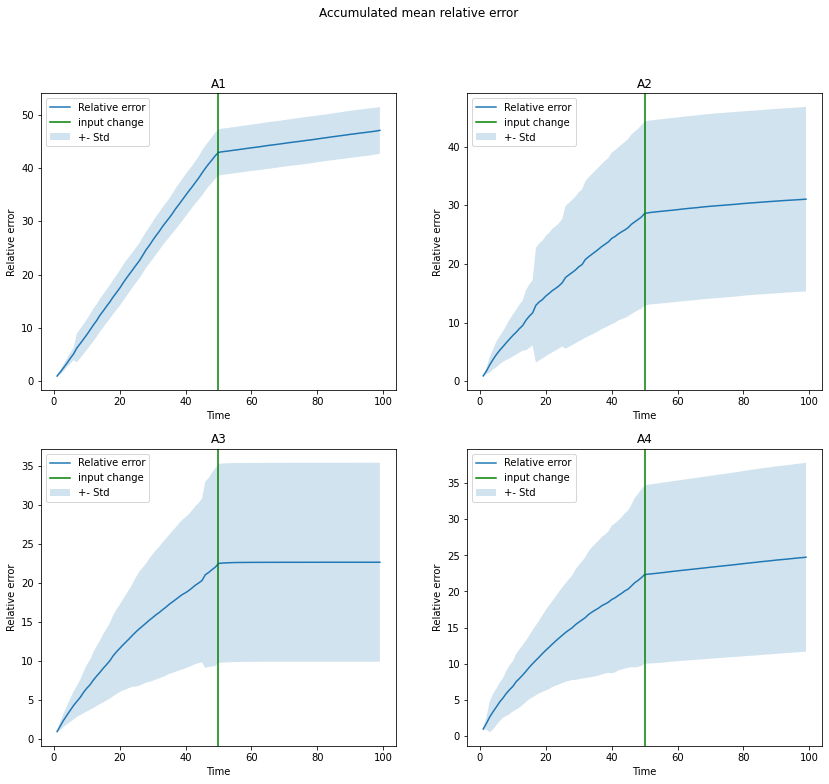

In [15]:
names = ["A1", "A2", "A3", "A4"]
plot_errors(results,names = names,max_t = 100)

Como podemos observar, para todas las matrices que representan un sistema tenemos un crecimiento *pseudo-lineal* del error hasta llegar al instante de tiempo $t=50$. Recordamos que la entrada $u_t$ "activa" la matriz $\mathbf B$ en la simulación **real** del sistema y , en el filtro de Kalman, *activa* esta misma matriz en la predición a 
priori
$$
\bar x_{t+1} = \mathbf{A}\bar x_t + \mathbf B u_t.
$$
En un sistema matricial, podemos considerar esta matriz $\mathbf B$ como el término independiente de la ecuación, y afirmar así que al utilizar el término independiente las predicciones de nuestro filtro de Kalman se parecen mucho más a los valores reales que se obtienen de simular directamente el sistema desde un punto inicial.

Recordamos que, en este instante de tiempo nuestra función *input* empieza a devolver $1.0$ en lugar de $0.0$. Esto se aplica tanto en la estimación como en la salida observada, por lo que estamos aumentando la norma de ambas, lo cual reduce el error relativo (tenemos el mismo error pero en magnitudes mayores de norma).

Se observa como el error que se acumula a partir de este instante $t=50$ es, en media, mucho más pequeño que en los casos anteriores. Se frena en seco el crecimiento del error acumulado en los instantes anteriores a $t$ para $t > 50$. En el próximo apartado estudiaremos por qué puede ocurrir esto.

## Apartado c

Vamos a estudiar a continuación el **error relativo individualizado** para obtener más información sobre el sistema determinado por cada matriz $\mathbf A_i$.

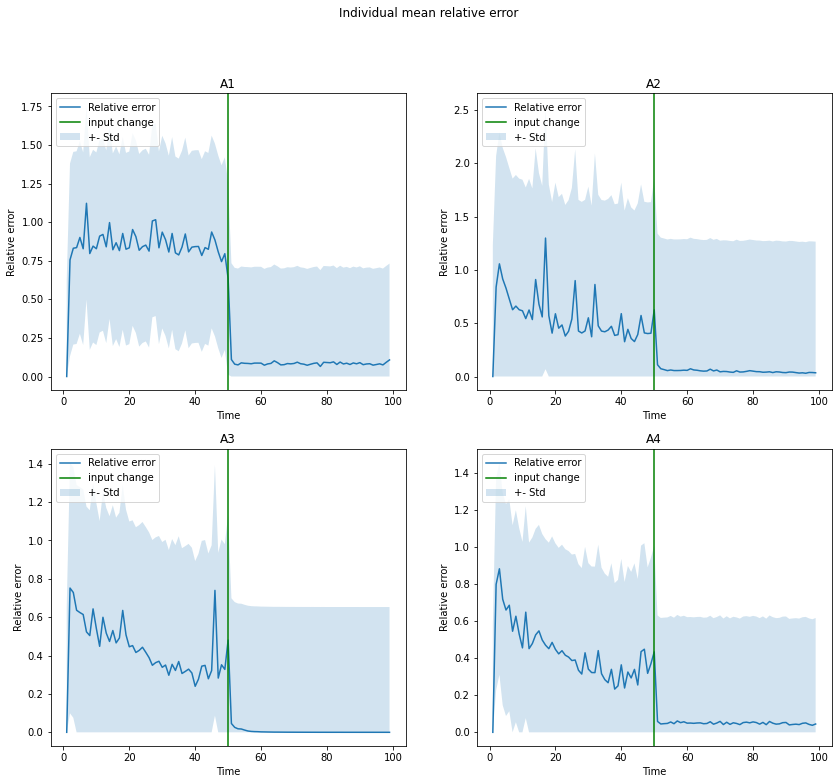

In [16]:

plot_individual_error(results,names,max_t = 100)

Como podemos observar, el error relativo medio individualizado desciende drásticamente en todos los casos tras sobrepasar la "barrera" en la que la función $u_f(t)$ empieza a valer $1$. 

Mirando las gráficas de forma no detenida, podría pensarse que todos los errores medios relativos tienen un descenso considerable y que convergen a cero. Sin embargo, podemos fijarnos un poco más detenidamente en lo siguiente:

In [17]:
def plot_close(results,x_range ,names, max_t):
    
    xs = x_range
    
    fig,ax = plt.subplots(figsize = (12,8))
    
    
    for k in range(results.shape[0]):
        
        ys =  [results[k][0][i] - results[k][0][i-1] for i in xs]
        
        ax.plot(xs, ys, label = "{}".format(names[k]),linewidth = 2.5 )
        
    
    ax.set_xlabel("Time")
    ax.set_ylabel("Relative error")    
    ax.legend(loc = "upper right")
    ax.set_title("Individual mean relative error")
    ax.legend(loc="upper right")
    plt.show()

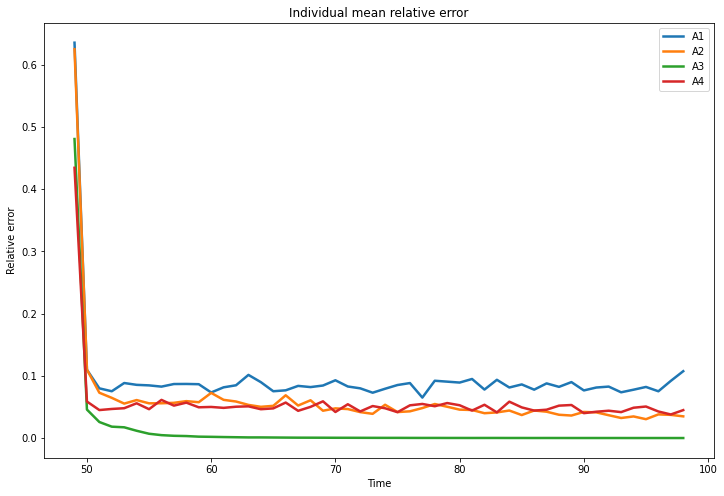

In [18]:
plot_close(results,np.arange(49,99,1),names,max_t = 100)

Como podemos comprobar, en el caso de las matrices $\mathbf A_1$ y $\mathbf A_4$, los errores relativos no convergen a cero. Se tiene que:

- La matriz $\mathbf A_1$ obtiene un valor que podría parecer que está estabilizado en un valor cercano a $0.1$ de error relativo, pero si comparamos con la convergencia que tienen las matrices $A_3$

- La matriz $\mathbf A_4$, aunque se mueva en valores pequeños de error, oscila de forma muy brusca y no se estabiliza en los primeros $100$ instantes de tiempo.


Que el sistema dado por la matriz $\mathbf A_1$ no va a converger parece bastante claro. El caso del sistema con matriz $\mathbf A_4$ puede ser más dudoso. Para comprobar empíricamente si va a converger, podemos realizar el experimento usando un número mucho mayor de instantes de tiempo para comprobar qué ocurre. Lo realizamos simplemente llamando a la función `experiment` pasándole como parámetro `max_t = 1000`.


In [ ]:
results_long = experiment(As, max_t = 1000,  n_runs = 50)


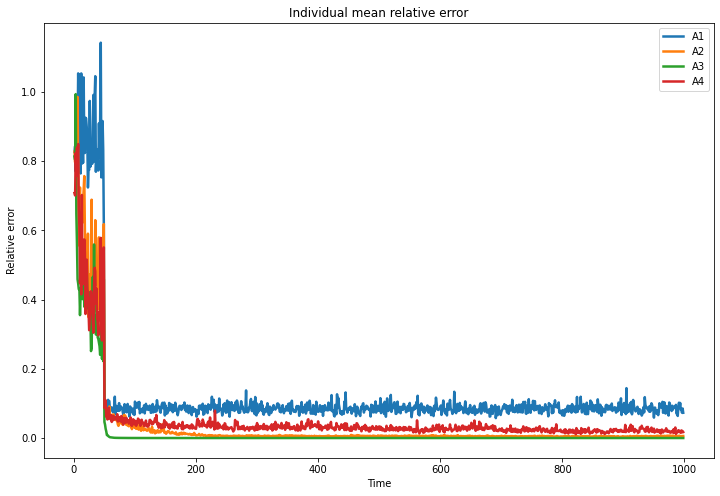

In [20]:
plot_close(results_long,np.arange(1,999,1),names,max_t = 100)

Igual que ocurría antes, tenemos que los errores son bastante más grandes al principio hasta el punto en el que en $t = 50$ empezamos a usar el input $u_t$. Podemos acercar un poco la vista dibujando los valores en el intervalo $t \in [400,500]$ para ver más de cerca el comportamiento que tiene en esos instantes de tiempo el sistema para las matrices anteriores.

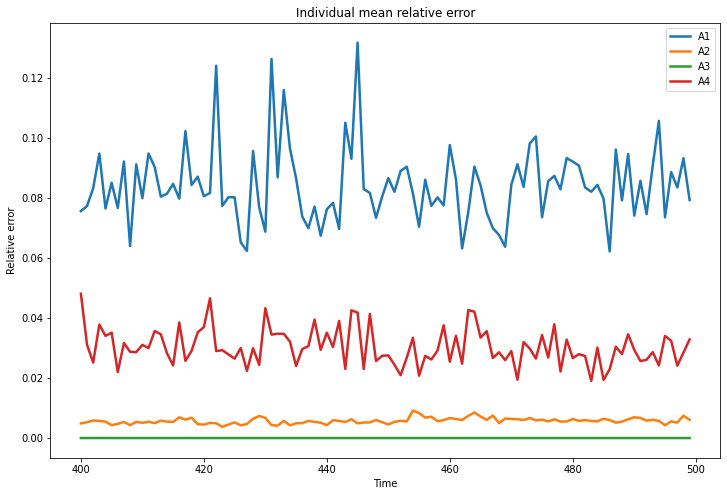

In [21]:
plot_close(results_long,np.arange(400,500,1),names,max_t = 100)

Como se puede observar, como ya predecíamos anteriormente, que la simulación usando el filtro de Kalman de los sistemas dados por la matriz $\mathbf A_1$ y $\mathbf A_4$ no converge los valores reales del sistema. 

### Análisis usando los valores propios

Nos gustaría dar un razonamiento teórico de por qué tenemos estos problemas de estabilidad y convergencia para los valores generados usando el filtro de Kalman. Para ello, nos remontamos a ver los valores propios que tienen las matrices $\mathbf A_i$ que tienen nuestros sistemas dinámicos:

Las matrices que hacen que los valores del filtro de Kalman converjan tienen valores propios:

$$
\Lambda_2 = [ 0.99, 0.1, 0.0, -0.1 ]
$$
$$
\Lambda_3 = [ 1.0, 0.1, 0.0, -0.1 ]
$$

Sin embargo, las matrices que tienen valores propios
$$
\Lambda_1 = [ 0.2, 0.1, 0.0, -0.1 ]
$$
$$
\Lambda_4 = [ 0.2, 0.1, 0.0, -1.0 ]
$$

hacen que el filtro de Kalman no converja a la solución original. 

La **diferencia** que se puede observar entre los valores propios de las matrices que nos dan la convergencia y las matrices que no, es si usamos  **matrices que tienen un valor propio $1$** o **un valor propio muy cercano a uno**, obtenemos menores errores relativos al realizar la aproximación mediante el filtro de Kalman. Esto significa que si tenemos este tipo de valores propios, el filtro de Kalman es más estable. 

Podemos decir por tanto como **conclusión** que la convergencia del filtro de Kalman viene dada por el hecho de que la matriz tenga, o no, un valor propio $\lambda = 1$.
